# **Analisis Ulasan Netizen Terhadap Aplikasi Dana di Google Playstore menggunakan Recurrent Neural Network (RNN)**

**Kelompok 66 — Mata Kuliah Deep Learning**  
Universitas Pendidikan Indonesia  
Semester 5 — Tahun 2025  

---

### Anggota:
- Muhamad Khafabillah Sopian (2307824)  
- Abyan Laksono (2304127)  

---


### **Import Library**

Pada tahap ini dilakukan import pustaka (library) yang dibutuhkan untuk melakukan pemrosesan data teks, pembuatan model RNN, serta evaluasi hasilnya.

Fungsi utama setiap library:

pandas → membaca dan mengelola dataset.

numpy → menangani operasi matematis pada array.

re & string → membersihkan teks menggunakan regular expressions.

scikit-learn → menyediakan fungsi train-test split dan metrik evaluasi seperti classification report serta confusion matrix.

tensorflow.keras → membangun dan melatih model RNN.
Termasuk komponen seperti Embedding, SimpleRNN, Dense, dan Dropout.

matplotlib → membantu membuat grafik visualisasi data.

In [12]:
# Import library utama

import pandas as pd
import numpy as np
import re, string
import tensorflow as tf # PENTING: Tambahkan tf secara eksplisit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
# Tambahkan SimpleRNN dan Adam secara eksplisit untuk kejelasan
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random # Untuk seed

### **Load Data**

Dataset yang digunakan berisi ulasan pengguna (netizen) terhadap aplikasi Dana yang diambil dari Google Playstore.
Setiap ulasan telah diberi label sentimen:

positif — ulasan bernada dukungan, apresiasi, atau kepuasan.

negatif — ulasan bernada kritik, keluhan, atau ketidakpuasan.

netral — ulasan yang bersifat informatif atau kurang menunjukkan emosi yang kuat.

In [13]:
# instal dan import library gdown
!pip install gdown -q
import gdown, pandas as pd

# Tentukan ID file dari Google Drive untuk dataset 'review_dana_labelled.csv'
file_id = "1iFsoFUEFET_D9Q0aIKsBimWNX6nVa2Or"

# Buat URL unduhan
url = f"https://drive.google.com/uc?id={file_id}"
output = "review_dana_labelled.csv"

# Unduh file dari Google Drive
print(f"Memulai pengunduhan file: {output}...")
gdown.download(url, output, quiet=False)

# Baca file CSV ke dalam DataFrame pandas
# Menggunakan sep=None, engine="python" untuk penanganan format CSV yang fleksibel
try:
    df = pd.read_csv(output, sep=None, engine="python", encoding="utf-8")
except Exception:
    # Jika gagal, coba dengan delimiter koma standar
    print("Gagal membaca file dengan deteksi otomatis. Mencoba dengan delimiter koma (',').")
    df = pd.read_csv(output, encoding="utf-8")

# Tampilkan info dan 5 baris pertama untuk memastikan data berhasil dimuat
print("\nPengunduhan dan Pemuatan Dataset Selesai.")
print("\nInformasi Dataset:")
df.info()
print("\n5 Baris Pertama Dataset:")
df.head()

Memulai pengunduhan file: review_dana_labelled.csv...


Downloading...
From: https://drive.google.com/uc?id=1iFsoFUEFET_D9Q0aIKsBimWNX6nVa2Or
To: /content/review_dana_labelled.csv
100%|██████████| 4.89M/4.89M [00:00<00:00, 62.3MB/s]



Pengunduhan dan Pemuatan Dataset Selesai.

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  50000 non-null  object
 1   score     50000 non-null  int64 
 2   at        50000 non-null  object
 3   content   50000 non-null  object
 4   sentimen  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB

5 Baris Pertama Dataset:


,userName,score,at,content,sentimen
0,Elisya Kasni,5,2024-02-15 11:24:56,Bagus,POSITIVE
1,Rusman Man,2,2024-02-15 11:24:03,Dana mmg keren mantap.,POSITIVE
2,Qiliw Sadega,1,2024-02-15 11:23:34,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


## **Exploratory Data Analysis (EDA)**

Tahap Eksplorasi Data ini bertujuan untuk memahami pola dan struktur dataset ulasan Dana secara menyeluruh sebelum pemodelan. Analisis utama yang dilakukan adalah pemeriksaan **Distribusi Label Sentimen** dan **Distribusi Panjang Teks (Ulasan)**. Dari distribusi sentimen, akan diketahui keseimbangan jumlah data pada ketiga kelas: positif, negatif, dan netral. Hasil ini penting karena dataset ulasan cenderung **tidak seimbang**, yang harus dipertimbangkan saat mengevaluasi kinerja model. Sementara itu, analisis panjang teks ulasan sangat krusial untuk menentukan parameter panjang maksimum teks (`MAX_LEN`) saat melakukan *padding*. Parameter `MAX_LEN` yang tepat akan memastikan mayoritas ulasan tercakup tanpa membebani model RNN dengan *padding* yang berlebihan, sehingga mendukung strategi pra-pemrosesan dan penentuan ukuran input yang efisien.

Distribusi Jumlah Data per Sentimen:
sentimen
POSITIVE    26555
NEGATIVE    17073
NEUTRAL      6372
Name: count, dtype: int64
------------------------------


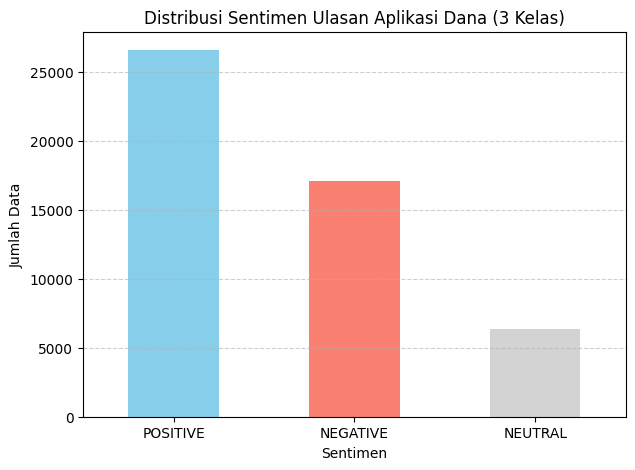

Statistik Deskriptif Panjang Teks (Jumlah Kata):
count    50000.000000
mean         8.558440
std         12.513374
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max         98.000000
Name: temp_word_count, dtype: float64
------------------------------


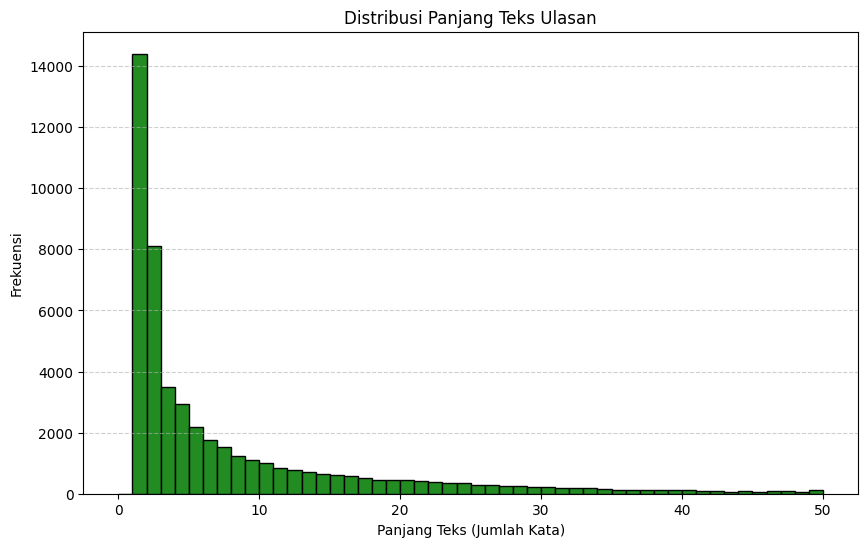

Panjang Teks pada Persentil ke-95 (Acuan MAX_LEN): 34 kata


In [4]:
# Distribusi Label Sentimen

print("Distribusi Jumlah Data per Sentimen:")
sentiment_counts = df['sentimen'].value_counts()
print(sentiment_counts)
print("-" * 30)

# Visualisasi distribusi label
plt.figure(figsize=(7, 5))

# Urutan warna diatur sesuai urutan default value_counts (Positive, Negative, Neutral)
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgray'])
plt.title('Distribusi Sentimen Ulasan Aplikasi Dana (3 Kelas)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Distribusi Panjang Teks

# Hitung jumlah kata pada kolom 'content'
df['temp_word_count'] = df['content'].apply(lambda x: len(str(x).split()))

# Menampilkan statistik deskriptif panjang teks
print("Statistik Deskriptif Panjang Teks (Jumlah Kata):")
print(df['temp_word_count'].describe())
print("-" * 30)

# Visualisasi distribusi panjang teks menggunakan histogram
plt.figure(figsize=(10, 6))

# Batasi sumbu x hingga 50 kata untuk melihat distribusi inti, karena kebanyakan ulasan pendek
plt.hist(df['temp_word_count'], bins=50, range=(0, 50), color='forestgreen', edgecolor='black')
plt.title('Distribusi Panjang Teks Ulasan')
plt.xlabel('Panjang Teks (Jumlah Kata)')
plt.ylabel('Frekuensi')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Menentukan persentil ke-95 sebagai acuan MAX_LEN
max_len_percentile = int(np.percentile(df['temp_word_count'], 95))
print(f"Panjang Teks pada Persentil ke-95 (Acuan MAX_LEN): {max_len_percentile} kata")

# Hapus kolom temporer
df.drop(columns=['temp_word_count'], inplace=True)

## **Praproses**

Tahap ini sangat penting untuk mengubah data teks mentah menjadi representasi numerik yang siap diproses oleh model RNN. Prosesnya dimulai dengan **Pembersihan Teks**, di mana ulasan dibersihkan dari simbol, tautan, atau angka yang tidak relevan, serta diseragamkan ke huruf kecil. Selanjutnya, dilakukan **Penanganan Baris Kosong** dan **Penanganan Duplikat** untuk memastikan kualitas dan keunikan data, yang sangat penting untuk mencegah *overfitting* saat pelatihan. Setelah teks bersih, **Label Encoding** dilakukan untuk mengubah label sentimen kategorikal (NEGATIVE, NEUTRAL, POSITIVE) menjadi nilai numerik (0, 1, 2) yang dapat dipahami oleh model. Langkah terakhir adalah **Tokenisasi dan Padding**, yaitu mengubah setiap kata menjadi indeks numerik dan menyeragamkan panjang semua urutan teks menjadi 35 kata (`MAX_LEN`) menggunakan *padding* agar input model memiliki dimensi yang seragam.

In [6]:
# Tentukan parameter yang akan digunakan dari hasil EDA
MAX_VOCAB = 10000  # Maksimal kata unik
MAX_LEN = 35       # Panjang sekuens (dari persentil 95% di analisis sebelumnya)

# Pembersihan Teks

def clean_text(teks):
    teks = str(teks).lower()
    # hapus URL, mention, hashtag
    teks = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", teks)
    # hapus simbol & tanda baca (pertahankan a-z, 0-9, dan spasi)
    teks = re.sub(r"[^a-z0-9\s]", " ", teks)
    # rapikan spasi
    teks = re.sub(r"\s+", " ", teks).strip()
    return teks

# Terapkan pembersihan
df['clean_text'] = df['content'].apply(clean_text)

# Hitung jumlah kata setelah pembersihan
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

print(f"Jumlah total data awal: {len(df)}")
print(f"Batas panjang teks (MAX_LEN): {MAX_LEN}")
print("-" * 40)

Jumlah total data awal: 50000
Batas panjang teks (MAX_LEN): 35
----------------------------------------


In [7]:
# Penanganan Baris Kosong dan Duplikat

# Buang ulasan kosong (word_count == 0) dan pastikan label valid
df = df[df['word_count'] > 0].reset_index(drop=True)
df['sentimen'] = df['sentimen'].astype(str).str.upper().str.strip()
label_valid = {'NEGATIVE', 'NEUTRAL', 'POSITIVE'}
df = df[df['sentimen'].isin(label_valid)].reset_index(drop=True)

before_dedup = len(df)
# Hapus duplikat berdasarkan gabungan konten + label
df = df.drop_duplicates(subset=['content', 'sentimen']).reset_index(drop=True)
after_dedup = len(df)

print(f"Baris tersisa setelah buang kosong: {before_dedup}")
print(f"Duplikat terhapus: {before_dedup - after_dedup}")
print(f"Jumlah data akhir: {after_dedup}")
print("-" * 40)

Baris tersisa setelah buang kosong: 49383
Duplikat terhapus: 17904
Jumlah data akhir: 31479
----------------------------------------


In [8]:
# Label Encoding

# Ubah label teks menjadi angka (0: NEGATIVE, 1: NEUTRAL, 2: POSITIVE)
label2id = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
df['label_id'] = df['sentimen'].map(label2id)
y = np.array(df['label_id'])

print("Distribusi label akhir:")
print(df['sentimen'].value_counts())
print("-" * 40)

Distribusi label akhir:
sentimen
NEGATIVE    14030
POSITIVE    11524
NEUTRAL      5925
Name: count, dtype: int64
----------------------------------------


In [9]:
# Tokenisasi dan Padding

# Inisialisasi tokenizer
# MAX_VOCAB (10000) sudah didefinisikan di Cell 1
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="")
# Fit hanya pada data bersih ('clean_text')
tokenizer.fit_on_texts(df['clean_text'])

# Ubah teks menjadi deretan indeks angka (sequences)
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Padding: samakan panjang sekuens (X)
# MAX_LEN (35) sudah didefinisikan di Cell 1
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print("Contoh hasil tokenisasi & padding (X[0]):")
print(X[0])
print(f"\nPanjang input (X): {X.shape}")
print(f"Panjang label (y): {y.shape}")

Contoh hasil tokenisasi & padding (X[0]):
[24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]

Panjang input (X): (31479, 35)
Panjang label (y): (31479,)


## **Split Data Latih dan Validasi**

Tahap ini membagi dataset yang telah diproses (`X` dan `y`) menjadi dua subset: Data Latih (80%), yang digunakan untuk melatih model RNN, dan Data Validasi (20%), yang digunakan untuk mengevaluasi kinerja model setelah setiap *epoch* pelatihan. Pembagian dilakukan dengan strategi **stratified sampling** (`stratify=y`) untuk memastikan bahwa proporsi ketiga label sentimen (Negatif, Netral, Positif) pada data latih dan data validasi tetap seimbang dan merepresentasikan distribusi sentimen pada data total.

In [10]:
# Split data latih dan validasi (80%:20%)
# Menggunakan stratify=y untuk mempertahankan proporsi label di kedua set
# Menggunakan random_state=42 agar hasilnya konsisten
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Cek bentuk data hasil split
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "| y_val  :", y_val.shape)

# Lihat distribusi label di masing-masing subset
print("\nDistribusi label y_train (0: NEG, 1: NEU, 2: POS):", np.bincount(y_train))
print("Distribusi label y_val   (0: NEG, 1: NEU, 2: POS):", np.bincount(y_val))

X_train: (25183, 35) | y_train: (25183,)
X_val  : (6296, 35) | y_val  : (6296,)

Distribusi label y_train (0: NEG, 1: NEU, 2: POS): [11224  4740  9219]
Distribusi label y_val   (0: NEG, 1: NEU, 2: POS): [2806 1185 2305]


## **Membuat Model RNN Sederhana (SimpleRNN)**

Di tahap ini, kita akan membuat kerangka model Recurrent Neural Network yang paling sederhana, yaitu SimpleRNN. Tujuan utamanya adalah melakukan klasifikasi sentimen 3-kelas. Model ini dirancang dengan beberapa lapisan utama: dimulai dari **Lapisan Embedding** untuk mengubah setiap kata menjadi representasi angka, kemudian **Lapisan SimpleRNN** sebagai inti untuk memahami urutan teks, lalu **Lapisan Dropout** untuk mencegah *overfitting*, dan diakhiri dengan **Lapisan Dense** yang memberikan hasil prediksi sentimen (Negatif, Netral, atau Positif).

In [14]:
# Pastikan library sudah diimpor: Sequential, Embedding, SimpleRNN, Dense, Dropout, Adam
# dan import tensorflow as tf, numpy as np, random

# Tetapkan seed agar hasil pelatihan tetap konsisten
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Hitung ukuran vocabulary aktual
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

# Pembuatan Model SimpleRNN untuk klasifikasi 3 kelas
model_rnn = Sequential([
    # Lapisan Embedding: output_dim=128
    Embedding(input_dim=vocab_size, output_dim=128, input_length=MAX_LEN),

    # Lapisan SimpleRNN: 128 unit, dropout diaktifkan
    SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),

    # Dropout untuk mencegah overfitting
    Dropout(0.3),

    # Lapisan Dense (Tersembunyi)
    Dense(64, activation='relu'),

    # Lapisan Output: 3 unit (NEG, NEU, POS), menggunakan softmax
    Dense(3, activation='softmax')
])

# Kompilasi Model
from tensorflow.keras.optimizers import Adam
model_rnn.compile(
    optimizer=Adam(learning_rate=2e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Tentukan parameter pelatihan
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Latih model
history_rnn = model_rnn.fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1 # Tampilkan progress di setiap epoch
)

Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5933 - loss: 0.9066 - val_accuracy: 0.5964 - val_loss: 0.9369
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.6043 - loss: 0.8940 - val_accuracy: 0.6050 - val_loss: 0.9455
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.6036 - loss: 0.8953 - val_accuracy: 0.5902 - val_loss: 0.9517
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5966 - loss: 0.8997 - val_accuracy: 0.5975 - val_loss: 0.9516
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.6015 - loss: 0.8926 - val_accuracy: 0.5921 - val_loss: 0.9545
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5974 - loss: 0.8941 - val_accuracy: 0.5780 - val_loss: 0.9821
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5802 - loss: 0.9232 - val_accuracy: 0.5696 - val_loss: 0.9867
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5739 - loss: 0.9250 - 

In [18]:
# Hitung Akurasi Validasi dan Prediksi
# Menggunakan model_rnn yang sudah dilatih

# Menghitung Loss dan Akurasi Validasi
loss, accuracy = model_rnn.evaluate(X_val, y_val, verbose=0)

# Melakukan Prediksi Probabilitas pada Data Validasi
y_pred_probs = model_rnn.predict(X_val, verbose=0)

# Mengubah Probabilitas menjadi Label Kelas (0, 1, 2)
y_pred = np.argmax(y_pred_probs, axis=1)

# Definisikan nama label
target_names = ['NEGATIVE (0)', 'NEUTRAL (1)', 'POSITIVE (2)']

print(f"Akurasi Validasi Model RNN Sederhana: {accuracy:.4f}")
print(f"Loss Validasi: {loss:.4f}")

print("\n" + "="*50)
print("Classification Report:")
print("="*50)

# Classification Report
print(classification_report(y_val, y_pred, target_names=target_names))

print("\n" + "="*50)
print("Confusion Matrix:")
print("="*50)

# Confusion Matrix (ditampilkan sebagai DataFrame agar mudah dibaca)
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
print(cm_df)

Akurasi Validasi Model RNN Sederhana: 0.4752
Loss Validasi: 1.0127

Classification Report:
              precision    recall  f1-score   support

NEGATIVE (0)       0.47      0.90      0.62      2806
 NEUTRAL (1)       0.00      0.00      0.00      1185
POSITIVE (2)       0.50      0.20      0.29      2305

    accuracy                           0.48      6296
   macro avg       0.32      0.37      0.30      6296
weighted avg       0.39      0.48      0.38      6296


Confusion Matrix:
              NEGATIVE (0)  NEUTRAL (1)  POSITIVE (2)
NEGATIVE (0)          2529            0           277
NEUTRAL (1)            995            0           190
POSITIVE (2)          1842            0           463


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Evaluasi Model SimpleRNN Sederhana**

Setelah melatih model SimpleRNN selama 10 *epoch*, evaluasi dilakukan pada data validasi (`X_val`, `y_val`). Hasil evaluasi menunjukkan akurasi validasi sebesar **47.52%** dan *loss* validasi sebesar **1.0127**.

Berikut adalah rincian performa model berdasarkan *Classification Report* dan *Confusion Matrix*:

**Classification Report:**

| Sentimen       | Precision | Recall | F1-Score | Support |
|----------------|-----------|--------|----------|---------|
| NEGATIVE (0)   | 0.47      | 0.90   | 0.62     | 2806    |
| NEUTRAL (1)    | 0.00      | 0.00   | 0.00     | 1185    |
| POSITIVE (2)   | 0.50      | 0.20   | 0.29     | 2305    |
| **Accuracy**   |           |        | **0.48** | 6296    |
| **Macro Avg**  | 0.32      | 0.37   | 0.30     | 6296    |
| **Weighted Avg**| 0.39      | 0.48   | 0.38     | 6296    |

**Confusion Matrix:**

|               | NEGATIVE (0) | NEUTRAL (1) | POSITIVE (2) |
|---------------|--------------|-------------|--------------|
| NEGATIVE (0)  | 2529         | 0           | 277          |
| NEUTRAL (1)   | 995          | 0           | 190          |
| POSITIVE (2)  | 1842         | 0           | 463          |

**Analisis Hasil:**

*   **Akurasi yang Rendah:** Akurasi keseluruhan model (47.52%) masih tergolong rendah, menunjukkan bahwa model SimpleRNN sederhana ini belum mampu mengklasifikasikan sentimen dengan baik.
*   **Masalah Kelas Netral:** Model kesulitan memprediksi kelas Netral (1). Terlihat dari *precision*, *recall*, dan *f1-score* untuk kelas Netral yang bernilai 0. Ini juga terlihat jelas pada *Confusion Matrix* di mana tidak ada satupun data Netral yang diprediksi sebagai Netral. Data Netral mayoritas salah diklasifikasikan sebagai Negatif atau Positif.
*   **Bias ke Kelas Negatif:** Model cenderung memprediksi sebagian besar data sebagai Negatif, terlihat dari *recall* yang tinggi untuk kelas Negatif (0.90) namun *precision* yang lebih rendah (0.47).
*   **Performa Kelas Positif:** Performa untuk kelas Positif juga masih rendah, dengan *recall* hanya 0.20.

Hasil ini mengindikasikan bahwa model SimpleRNN sederhana ini mungkin tidak cukup kompleks untuk menangani dataset ulasan dengan tiga kelas sentimen, terutama dengan adanya ketidakseimbangan data (meskipun telah menggunakan *stratified split*).

## **Pengujian Model Secara Manual**

Tahap ini digunakan untuk menguji kinerja model SimpleRNN yang telah dilatih dengan ulasan baru yang belum pernah dilihat. Ulasan baru akan melewati tahapan yang sama dengan data pelatihan (pembersihan teks, tokenisasi, dan *padding*) sebelum dimasukkan ke model untuk mendapatkan prediksi sentimen.

In [20]:
# Fungsi Inference untuk prediksi satu ulasan (Tanpa pemisah internal)
def predict_sentiment(review_text):
    # Pra-Pemrosesan: Bersihkan teks
    cleaned_text = clean_text(review_text)

    # Tokenisasi
    sequence = tokenizer.texts_to_sequences([cleaned_text])

    # Padding
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')

    # Prediksi Model
    prediction = model_rnn.predict(padded_sequence, verbose=0)[0]

    # Konversi hasil
    predicted_class_index = np.argmax(prediction)
    id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
    predicted_label = id2label.get(predicted_class_index, "UNKNOWN")

    # Tampilkan hasil
    print(f"Ulasan Asli: \"{review_text}\"")
    print(f"Teks Bersih: \"{cleaned_text}\"")
    print(f"Prediksi Sentimen: {predicted_label} (Indeks: {predicted_class_index})")
    print(f"Probabilitas Kelas: {prediction}")

# --- UJI COBA MANUAL ---

# Ulasan Contoh 1
predict_sentiment("aplikasi yang cukup baik.")
print("\n" + "="*50 + "\n") # PEMISAH BARIS

# Ulasan Contoh 2
predict_sentiment("tidak bagus.")
print("\n" + "="*50 + "\n") # PEMISAH BARIS

# Ulasan Contoh 3
predict_sentiment("UI dari aplikasinya simpel bagus.")
print("\n" + "="*50 + "\n") # PEMISAH BARIS

# Ulasan Contoh 4
predict_sentiment("UANG SAYA HILANG, APLIKASI LAKNAT.")
print("\n" + "="*50 + "\n") # PEMISAH BARIS

Ulasan Asli: "aplikasi yang cukup baik."
Teks Bersih: "aplikasi yang cukup baik"
Prediksi Sentimen: NEGATIVE (Indeks: 0)
Probabilitas Kelas: [0.407281   0.21861278 0.3741062 ]


Ulasan Asli: "tidak bagus."
Teks Bersih: "tidak bagus"
Prediksi Sentimen: NEGATIVE (Indeks: 0)
Probabilitas Kelas: [0.4072807  0.21861307 0.37410614]


Ulasan Asli: "UI dari aplikasinya simpel bagus."
Teks Bersih: "ui dari aplikasinya simpel bagus"
Prediksi Sentimen: NEGATIVE (Indeks: 0)
Probabilitas Kelas: [0.40728077 0.21861306 0.37410617]


Ulasan Asli: "UANG SAYA HILANG, APLIKASI LAKNAT."
Teks Bersih: "uang saya hilang aplikasi laknat"
Prediksi Sentimen: NEGATIVE (Indeks: 0)
Probabilitas Kelas: [0.40728104 0.21861275 0.3741062 ]




## **Kesimpulan Analisis Model RNN Sederhana (SimpleRNN)**

Analisis ini telah melalui tahap persiapan data yang cermat, mulai dari pra-pemrosesan, pembersihan teks, penghapusan duplikat, hingga tokenisasi dan *padding*, menghasilkan data yang siap untuk pelatihan model. Selanjutnya, arsitektur SimpleRNN dibangun dan dilatih selama 10 *epoch*.

Hasil evaluasi menunjukkan bahwa Model SimpleRNN ini **tidak mampu beroperasi secara efektif** pada tugas klasifikasi sentimen 3-kelas ini. Model hanya mencapai **Akurasi Validasi 47.52%**. Kinerja yang buruk ini berpuncak pada dua temuan kritis:

1.  **Kegagalan Total Kelas Netral:** *Classification Report* menunjukkan *F1-score* **0.00** untuk kelas Netral. Kegagalan ini dikonfirmasi oleh *Confusion Matrix* dan uji coba manual, di mana model tidak pernah berhasil memprediksi ulasan Netral, melainkan memiliki kecenderungan kuat untuk memprediksi **kelas Negatif** di hampir semua kasus, termasuk ulasan yang sebenarnya Positif atau Netral.
2.  **Kelemahan Arsitektur:** Kegagalan ini adalah cerminan dari kelemahan bawaan SimpleRNN dalam menangani *long-term dependencies* (*vanishing gradient*). Arsitektur yang sederhana ini tidak dapat mempelajari pola halus dari kelas minoritas pada dataset yang tidak seimbang.

**Kesimpulan Akhir:** Berdasarkan performa yang sangat rendah dan ketidakmampuan model dalam membedakan kelas Netral, Model SimpleRNN Sederhana ini **tidak direkomendasikan** untuk digunakan sebagai solusi klasifikasi sentimen untuk dataset ulasan ini.